In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from functools import partial

# Data Handling
This notebook is created for visulalising the data and try out different ways to fit copula.


## Data
Three datasets. 
1. Bitcoin Future from CME
    - Downloaded from Bloomberg
    - From 2017-12-15 to 2021-02-03
    - Consist of BTCH1 Curncy, BTCZ0 Curncy, BTCU0 Curncy, BTCM0 Curncy, BTCH0 Curncy, BTCZ19 Curncy, BTCU19 Curncy, BTCM19 Curncy, BTCH19 Curncy, BTCZ18 Curncy, BTCU18 Curncy, BTCM18 Curncy, BTCH18 Curncy, 
    - OHLC and volume data
    - Daily data

2. BRR 
    - BRR is the reference rate of Bitcoin used by the Bitcoin future
    - Same period of time of Bitcoin future
    - Also from Bloomberg
    
3. CRIX
    - Download from CRIX http://data.thecrix.de/data/crix.json
    - Daily data
    - from 2014-07-31 to 2021-02-03
    - Weights of constituents change across time; Dataset does not include this;


## Using Scipy.stats.kendalltau
Using scipy is the easiest way to get kendall's tau. (https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.kendalltau.html)

According to the documentation of Scipy, the function return the 1945 "tau-b" version of Kendall's tau. 

In [287]:
crix_link = "http://data.thecrix.de/data/crix.json"

import urllib.request, json 
with urllib.request.urlopen(crix_link) as url:
    data = json.loads(url.read().decode())

crix = pd.DataFrame(data)

In [288]:
crix.columns = ['Date', 'index']
crix.Date = pd.to_datetime(crix.Date)

In [289]:
future = pd.read_excel("../data/btc future and reference rate/btc_future.xlsx")
# future = pd.read_excel("../data/CryptoRelated/BTC CME Future.xlsx")
brr = pd.read_excel("../data/btc future and reference rate/btc_referencerate.xlsx")

In [290]:
crix_future = crix.merge(future,'inner', on='Date', suffixes=(" crix", " future"))
crix_future = crix_future.iloc[:,[0,1,5]]
crix_future.dropna(inplace=True)
crix_future = crix_future.sort_values("Date", ascending=False).reset_index(drop=True)

In [291]:
crix_brr = crix.merge(brr,'inner', on='Date', suffixes=(" crix", " future"))
# crix_brr = crix_brr.iloc[:,[0,1,5]]
crix_brr.dropna(inplace=True)
crix_brr = crix_brr.sort_values("Date", ascending=False).reset_index(drop=True)

In [292]:
future_brr = future.merge(brr, 'inner', on='Date', suffixes=(" future", " brr"))
future_brr = future_brr.iloc[:,[0,4,10]]
future_brr.dropna(inplace=True)

In [293]:
training_size = 500
testing_size = 30
(len(crix_brr)-training_size)/testing_size

19.266666666666666

In [294]:
8*30

240

In [295]:
np.log(crix_brr.iloc[:,1:]/crix_brr.iloc[:,1:].shift(-1))

,index,Open,High,Low,Close
0,0.059741,0.055267,0.055267,0.055267,0.055267
1,0.002204,0.038782,0.038782,0.038782,0.038782
2,-0.028318,0.013069,0.013069,0.013069,0.013069
3,0.009938,-0.035872,-0.035872,-0.035872,-0.035872
4,0.032007,-0.083796,-0.083796,-0.083796,-0.083796
5,0.081917,0.151434,0.151434,0.151434,0.151434
6,-0.069425,0.066118,0.066118,0.066118,0.066118
7,0.005862,-0.053736,-0.053736,-0.053736,-0.053736
8,0.001026,-0.084122,-0.084122,-0.084122,-0.084122
9,0.007870,0.067842,0.067842,0.067842,0.067842


In [296]:
log_returns = np.log(future_brr.iloc[:,1:]/future_brr.iloc[:,1:].shift(-1))
log_returns_crix = np.log(crix_future.iloc[:,1:]/crix_future.iloc[:,1:].shift(-1))
log_returns_crix_brr = np.log(crix_brr.iloc[:,1:]/crix_brr.iloc[:,1:].shift(-1))

In [297]:
future_brr.loc[:,'log return future'] = log_returns.iloc[:,0]
future_brr.loc[:,'log return brr'] = log_returns.iloc[:,1]

In [298]:
crix_future.loc[:,'log return crix'] = log_returns_crix.iloc[:,0]
crix_future.loc[:,'log return future'] = log_returns_crix.iloc[:,1]

In [299]:
crix_brr.loc[:,'log return crix'] = log_returns_crix_brr.iloc[:,0]
crix_brr.loc[:,'log return brr'] = log_returns_crix_brr.iloc[:,1]

In [300]:
# 2018-02-09 to 2020-09-04
future_brr = future_brr.iloc[:-1,:]
crix_future = crix_future.iloc[:-1,:]
crix_brr = crix_brr.iloc[:-1,:]

In [262]:
crix_brr

,Date,index,Open,High,Low,Close,log return crix,log return brr
0,2021-02-03,98949.179255,36777.83,36777.83,36777.83,36777.83,0.059741,0.055267
1,2021-02-02,93210.948461,34800.37,34800.37,34800.37,34800.37,0.002204,0.038782
2,2021-02-01,93005.711051,33476.58,33476.58,33476.58,33476.58,-0.028318,0.013069
3,2021-01-31,95677.076983,33041.92,33041.92,33041.92,33041.92,0.009938,-0.035872
4,2021-01-30,94730.919657,34248.72,34248.72,34248.72,34248.72,0.032007,-0.083796
5,2021-01-29,91746.863103,37242.30,37242.30,37242.30,37242.30,0.081917,0.151434
6,2021-01-28,84530.856368,32008.82,32008.82,32008.82,32008.82,-0.069425,0.066118
7,2021-01-27,90607.923382,29960.92,29960.92,29960.92,29960.92,0.005862,-0.053736
8,2021-01-26,90078.347878,31614.93,31614.93,31614.93,31614.93,0.001026,-0.084122
9,2021-01-25,89986.000973,34389.51,34389.51,34389.51,34389.51,0.007870,0.067842


In [263]:
future_brr.loc[:,'YearMonth'] = future_brr.Date.apply(lambda x: x.strftime('%Y%m'))
crix_future.loc[:,'YearMonth'] = crix_future.Date.apply(lambda x: x.strftime('%Y%m'))
crix_brr.loc[:,'YearMonth'] = crix_brr.Date.apply(lambda x: x.strftime('%Y%m'))

In [264]:
YearMonth = future_brr.YearMonth.unique()
train_YM  = []
test_YM   = []
train = 12
test  = 1
for i in range(len(YearMonth)-train-test):
    train_YM.append(YearMonth[i+test:i+test+train])
    test_YM.append(YearMonth[i:i+test])

In [265]:
train_set = []
test_set = []
for i in range(len(train_YM)):
    train_id = future_brr.YearMonth.isin(list(train_YM[i]))
    train_data = future_brr.loc[train_id,['Date','log return future', 'log return brr']]
    train_set.append(train_data)
    
    test_id = future_brr.YearMonth.isin(list(test_YM[i]))
    test_data = future_brr.loc[test_id, ['Date','log return future', 'log return brr']]
    test_set.append(test_data)
    # list(train_YM[0])

In [269]:
np.mean([len(train_set[i]) for i in range(len(train_set))])

# 300 days / 500 days for training and 

252.04166666666666

In [229]:
for i in range(len(train_set)):
    train_set[i].to_csv("../processed_data/future_brr_v3/train/"+str(i)+".csv")
    test_set[i].to_csv("../processed_data/future_brr_v3/test/"+str(i)+".csv")

['Friday' 'Thursday' 'Wednesday' 'Tuesday' 'Monday']


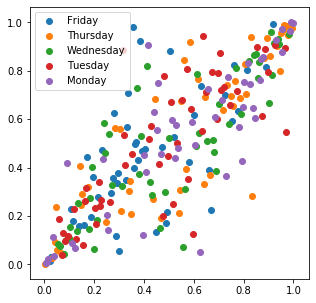

In [201]:
plt.figure(figsize=(5,5))
i=0

rf = train_set[i].loc[:,'log return future']
rs = train_set[i].loc[:,'log return brr']

ecdf_rf = ECDF(rf)
ecdf_rs = ECDF(rs)

DoW = train_set[i].Date.dt.day_name() # Day of Week
# colors = dict(zip(DoW.unique(), ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']))
print(DoW.unique())
for d in DoW.unique()[:]:
    ids = DoW == d
    plt.scatter(ecdf_rf(rf.loc[DoW==d]), ecdf_rs(rs.loc[DoW==d]), label=d)
plt.legend()

In [202]:
YearMonth = crix_future.YearMonth.unique()
train_YM  = []
test_YM   = []
train = 12
test  = 1
for i in range(len(YearMonth)-train-test):
    train_YM.append(YearMonth[i+test:i+test+train])
    test_YM.append(YearMonth[i:i+test])

In [203]:
train_set = []
test_set = []
for i in range(len(train_YM)):
    train_id = crix_future.YearMonth.isin(list(train_YM[i]))
    train_data = crix_future.loc[train_id,['Date','log return crix', 'log return future']]
    train_set.append(train_data)
    
    test_id = crix_future.YearMonth.isin(list(test_YM[i]))
    test_data = crix_future.loc[test_id, ['Date','log return crix', 'log return future']]
    test_set.append(test_data)
    # list(train_YM[0])

In [204]:
for i in range(len(train_set)):
    train_set[i].to_csv("../processed_data/crix_future/train/"+str(i)+".csv")
    test_set[i].to_csv("../processed_data/crix_future/test/"+str(i)+".csv")

['Friday' 'Thursday' 'Wednesday' 'Tuesday' 'Monday']


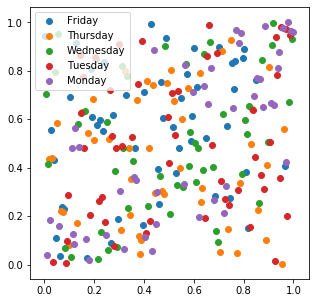

In [207]:
plt.figure(figsize=(5,5))
i=12

rf = train_set[i].loc[:,'log return crix']
rs = train_set[i].loc[:,'log return future']

ecdf_rf = ECDF(rf)
ecdf_rs = ECDF(rs)

DoW = train_set[i].Date.dt.day_name() # Day of Week
# colors = dict(zip(DoW.unique(), ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']))
print(DoW.unique())
for d in DoW.unique()[:]:
    ids = DoW == d
    plt.scatter(ecdf_rf(rf.loc[DoW==d]), ecdf_rs(rs.loc[DoW==d]), label=d)
plt.legend()

['Thursday' 'Wednesday' 'Tuesday' 'Monday' 'Friday']


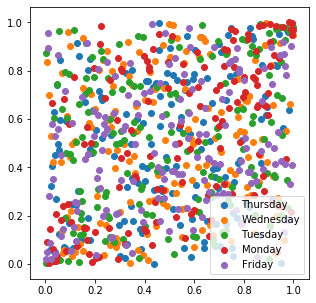

In [209]:
plt.figure(figsize=(5,5))
i=12

# rf = train_set[i].loc[:,'log return crix']
# rs = train_set[i].loc[:,'log return future']

rf = crix_future.loc[:,'log return crix']
rs = crix_future.loc[:,'log return future']

ecdf_rf = ECDF(rf)
ecdf_rs = ECDF(rs)

DoW = crix_future.Date.dt.day_name() # Day of Week
# colors = dict(zip(DoW.unique(), ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']))
print(DoW.unique())
for d in DoW.unique()[:]:
    ids = DoW == d
    plt.scatter(ecdf_rf(rf.loc[DoW==d]), ecdf_rs(rs.loc[DoW==d]), label=d)
plt.legend()

In [210]:
YearMonth = crix_brr.YearMonth.unique()
train_YM  = []
test_YM   = []
train = 12
test  = 1
for i in range(len(YearMonth)-train-test):
    train_YM.append(YearMonth[i+test:i+test+train])
    test_YM.append(YearMonth[i:i+test])

In [212]:
train_set = []
test_set = []
for i in range(len(train_YM)):
    train_id = crix_brr.YearMonth.isin(list(train_YM[i]))
    train_data = crix_brr.loc[train_id,['Date','log return crix', 'log return brr']]
    train_set.append(train_data)
    
    test_id = crix_brr.YearMonth.isin(list(test_YM[i]))
    test_data = crix_brr.loc[test_id, ['Date','log return crix', 'log return brr']]
    test_set.append(test_data)
    # list(train_YM[0])

In [214]:
for i in range(len(train_set)):
    train_set[i].to_csv("../processed_data/crix_brr/train/"+str(i)+".csv")
    test_set[i].to_csv("../processed_data/crix_brr/test/"+str(i)+".csv")

['Sunday' 'Saturday' 'Friday' 'Thursday' 'Wednesday' 'Tuesday' 'Monday']


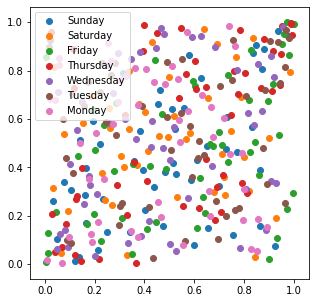

In [225]:
plt.figure(figsize=(5,5))
i=0

rf = train_set[i].loc[:,'log return crix']
rs = train_set[i].loc[:,'log return brr']

# rf = crix_brr.loc[:,'log return crix']
# rs = crix_brr.loc[:,'log return brr']

ecdf_rf = ECDF(rf)
ecdf_rs = ECDF(rs)

DoW = train_set[i].Date.dt.day_name() # Day of Week
# colors = dict(zip(DoW.unique(), ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']))
print(DoW.unique())
for d in DoW.unique()[:]:
    ids = DoW == d
    plt.scatter(ecdf_rf(rf.loc[DoW==d]), ecdf_rs(rs.loc[DoW==d]), label=d)
plt.legend()

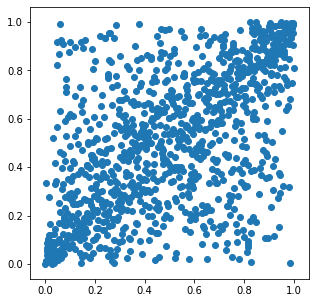

In [236]:
plt.figure(figsize=(5,5))
i=12

# rf = train_set[i].loc[:,'log return crix']
# rs = train_set[i].loc[:,'log return future']

rf = crix_brr.loc[:,'log return crix'].iloc[:-1]
rs = crix_brr.loc[:,'log return brr'].iloc[1:]

# rf = crix_brr.loc[:,'log return crix']
# rs = crix_brr.loc[:,'log return brr']

ecdf_rf = ECDF(rf)
ecdf_rs = ECDF(rs)
plt.scatter(ecdf_rf(rf), ecdf_rs(rs))

# DoW = crix_brr.Date.dt.day_name() # Day of Week
# # colors = dict(zip(DoW.unique(), ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']))
# print(DoW.unique())
# for d in DoW.unique()[:]:
#     ids = DoW == d
#     plt.scatter(ecdf_rf(rf.loc[DoW==d]), ecdf_rs(rs.loc[DoW==d]), label=d)
# plt.legend()

In [248]:
# The discordence comes from time difference!
import scipy
rf = crix_brr.loc[:,'log return crix']
rs = crix_brr.loc[:,'log return brr']
print(scipy.stats.kendalltau(rf,rs)[0])


0.22056195414662003


In [249]:
rf = crix_brr.loc[:,'log return crix'].iloc[:-1]
rs = crix_brr.loc[:,'log return brr'].iloc[1:]
print(scipy.stats.kendalltau(rf,rs)[0])

0.40697434159644513


In [244]:
# From the same timezone
rf = future_brr.loc[:,'log return future']
rs = future_brr.loc[:,'log return brr']
print(scipy.stats.kendalltau(rf,rs)[0])

0.5812980240048554


## 300/500 training 30 test, step size of 30

In [396]:
# Make sure the sizes are correct and no overlapping between testing and training, and among testings. 
step_size = 30
train_size = 500
i=4
data = future_brr.iloc[(i*step_size):((i+1)*step_size)+train_size]
test = data.iloc[:step_size,]
train = data.iloc[step_size:,]
print(test.iloc[0,0])
print(test.iloc[-1,0])
print(train.iloc[0,0])
print(train.iloc[-1,0])
print(len(test))
print(len(train))

2020-08-12 00:00:00
2020-07-01 00:00:00
2020-06-30 00:00:00
2018-07-09 00:00:00
30
500


In [397]:
step_size = 30
train_size = 500
i=3
data = future_brr.iloc[(i*step_size):((i+1)*step_size)+train_size]
test = data.iloc[:step_size,]
train = data.iloc[step_size:,]
print(test.iloc[0,0])
print(test.iloc[-1,0])
print(train.iloc[0,0])
print(train.iloc[-1,0])
print(len(test))
print(len(train))

2020-09-24 00:00:00
2020-08-13 00:00:00
2020-08-12 00:00:00
2018-08-20 00:00:00
30
500


In [408]:
step_size = 30
train_size = 500
n = int(np.floor((len(future_brr)-train_size)/step_size))

train_set = []
test_set = []

for i in range(n):
    data = future_brr.iloc[(i*step_size):((i+1)*step_size)+train_size]
    test = data.iloc[:step_size,]
    train = data.iloc[step_size:,]
    train_set.append(train)
    test_set.append(test)

for i in range(len(train_set)):
    train_set[i].to_csv("../processed_data/future_brr_v5/train/"+str(i)+".csv")
    test_set[i].to_csv("../processed_data/future_brr_v5/test/"+str(i)+".csv")

In [409]:
future_brr.head()

,Date,Close future,Close brr,log return future,log return brr
1,2021-02-03,37790.0,36777.83,0.033774,0.055267
2,2021-02-02,36535.0,34800.37,0.064146,0.038782
3,2021-02-01,34265.0,33476.58,-0.026353,-0.106599
4,2021-01-29,35180.0,37242.30,0.061398,0.151434
5,2021-01-28,33085.0,32008.82,0.036317,0.066118


In [411]:
train.tail()

,Date,Close future,Close brr,log return future,log return brr
739,2018-03-06,10650.0,10991.80,-0.086737,-0.043441
740,2018-03-05,11615.0,11479.82,0.048962,0.057410
741,2018-03-02,11060.0,10839.32,-0.000452,0.012873
742,2018-03-01,11065.0,10700.68,0.038697,0.016337
743,2018-02-28,10645.0,10527.28,-0.001408,-0.002511


## Code for slicing data

In [10]:
future_brr = pd.read_csv('../data/btc future and reference rate/coingecko_future.csv')
future_brr = future_brr.iloc[:,1:]
future_brr.columns = ['Date', 'Bitcoin Price', 'Future Price', 'bitcoin log return', 'future log return']

In [25]:
train_size = 300
test_size = 100
step_size = 5

In [107]:
import os
data_name = "coingecko_future_v5"
if os.path.exists("../processed_data/%s/" %data_name )==False:
    os.mkdir("../processed_data/%s/" %data_name)
    os.mkdir("../processed_data/%s/train/" %data_name)
    os.mkdir("../processed_data/%s/test/" %data_name)

In [62]:
len(future_brr)

678

In [108]:
# n = int(np.floor((len(future_brr)-train_size)/step_size))
n = int(np.floor((len(future_brr) - train_size - test_size)/step_size))
train_set = []
test_set = []

for i in range(n):
    data = future_brr.iloc[(i*step_size):((i)*step_size)+train_size+test_size]
    test = data.iloc[:test_size,]
    train = data.iloc[test_size:,]
    train_set.append(train)
    test_set.append(test)

for i in range(len(train_set)):
    train_set[i].to_csv("../processed_data/%s/train/" %data_name +str(i)+".csv")
    test_set[i].to_csv("../processed_data/%s/test/" %data_name +str(i)+".csv")

In [118]:
test_set[0].tail()

,Date,Bitcoin Price,Future Price,bitcoin log return,future log return
95,2020-09-17,10959.107673,10950.0,-0.005249,-0.005919
96,2020-09-16,11016.788324,11015.0,0.015720,0.018324
97,2020-09-15,10844.956029,10815.0,0.010277,0.010223
98,2020-09-14,10734.073851,10705.0,0.036930,0.034691
99,2020-09-11,10344.894473,10340.0,0.000183,0.002421


In [119]:
train_set[0].head()

,Date,Bitcoin Price,Future Price,bitcoin log return,future log return
100,2020-09-10,10343.005803,10315.0,0.009560,-0.000485
101,2020-09-09,10244.594756,10320.0,0.020643,0.030000
102,2020-09-08,10035.279584,10015.0,-0.052006,-0.058655
103,2020-09-04,10570.981189,10620.0,-0.015070,-0.009372
104,2020-09-03,10731.496510,10720.0,-0.058047,-0.066752
